In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

### Read in Data

In [3]:
start = datetime.now()

buys = pd.read_csv('data/yoochoose-buys.dat',
                   header=None,
                   names=['session_id','timestamp','item_id','price','quantity'])


#clicks = (pd.read_csv('data/yoochoose-clicks.dat',
##                     header=None,
#                    names = ['session_id','timestamp','item_id','category'])
#                    .sort_values('session_id')
#                
#        )


#clicks['timestamp'] = pd.to_datetime(clicks['timestamp'])

#From now on just read in the pickle file which has the dataframe above
clicks0 = pd.read_pickle('all_clicks_sorted_by_session.pkl')

buys['timestamp'] = pd.to_datetime(buys['timestamp'])

print 'Clicks: {}'.format(len(clicks0))
print 'Buys: {}'.format(len(buys))

print 'Elapsed time: {} minutes'.format((datetime.now() - start).seconds / 60.0)

Clicks: 33003944
Buys: 1150753
Elapsed time: 5.68333333333 minutes


In [11]:
clicks = pd.concat([clicks0.iloc[:100000],clicks0.iloc[-100000:]])
len(clicks)

200000

## Part 1: Will a session result in a purchase?
### Join clicks and buys session_id and item_id

In [12]:
buys1 = buys.groupby(['session_id','item_id']).agg({'price':np.mean,'quantity':np.sum}).reset_index()
buys1.head()

,session_id,item_id,price,quantity
0,11,214821371,1046.0,2
1,12,214717867,1778.0,4
2,21,214548744,3141.0,1
3,21,214838503,18745.0,1
4,33,214706441,1360.0,2


In [13]:
df = pd.merge(clicks,buys1,how='left',left_on=['session_id','item_id'],right_on=['session_id','item_id'])
df.shape

(200000, 6)

In [14]:
df.head()

,session_id,timestamp,item_id,category,price,quantity
0,1,2014-04-07 10:51:09.277,214536502,0,NaN,NaN
1,1,2014-04-07 10:54:09.868,214536500,0,NaN,NaN
2,1,2014-04-07 10:54:46.998,214536506,0,NaN,NaN
3,1,2014-04-07 10:57:00.306,214577561,0,NaN,NaN
4,2,2014-04-07 13:56:37.614,214662742,0,NaN,NaN


### Create Features

In [15]:
# Need to transform category
# Assuming that a float 0 and str 0 in the data are the same thing
# Assuming that length of 7 for category is just Brand
# There should be none named 'Error' if there is, need to manually inspect
def get_category(cat):
    cat = str(cat)
    if cat == "0":
        return "No Category"
    elif cat == "S":
        return "Special Offer"
    elif int(cat) > 0 and int(cat) < 13:
        return 'Regular Category'
    elif len(cat) > 6 and len(cat) < 11:
        return "Brand"
    return "Error"

df['category1'] = df['category'].apply(lambda x: get_category(x))

In [16]:
#This is what the df looks like after creating a dummy columns for categories

df = pd.concat([df,pd.get_dummies(df['category1'])],axis=1)
df.head()

,session_id,timestamp,item_id,category,price,quantity,category1,Brand,No Category,Regular Category,Special Offer
0,1,2014-04-07 10:51:09.277,214536502,0,NaN,NaN,No Category,0,1,0,0
1,1,2014-04-07 10:54:09.868,214536500,0,NaN,NaN,No Category,0,1,0,0
2,1,2014-04-07 10:54:46.998,214536506,0,NaN,NaN,No Category,0,1,0,0
3,1,2014-04-07 10:57:00.306,214577561,0,NaN,NaN,No Category,0,1,0,0
4,2,2014-04-07 13:56:37.614,214662742,0,NaN,NaN,No Category,0,1,0,0


In [17]:
#### Create some feature. Since we need to just predict whether a session will result in a buy or not, we 
#### roll up the data to session level and do some aggregations. The resulting features are: 
#### total clicks, unique items looked at, duration of session, unique categories looked at, total clicks for
#### each category, and our target- whether or not any purchase was made

In [18]:
start = datetime.now()
group1 = (df.groupby('session_id').agg({'category': np.size, 
                              'item_id': pd.Series.nunique,
                              'timestamp': lambda x: (x.max() - x.min()).seconds / 60.0 ,
                              'quantity': lambda x: int(all(x.notnull()))})
                                .rename(columns={'category':'total_clicks','item_id':'unique_items_seen',
                                                'timestamp':'duration','quantity':'buy'})
         )

group2 = (df.groupby('session_id')
            .agg({'category1': pd.Series.nunique,'timestamp':np.min})
            .rename(columns={'category1':'unique_categories_seen','timestamp':'first_click'})
         )
           
features0 = pd.merge(group1,group2,how='inner',left_index=True,right_index=True)
print 'Elapsed time: {} minutes'.format((datetime.now() - start).seconds / 60.0)

Elapsed time: 0.466666666667 minutes


In [19]:
#Get most common item (most clicks)
start = datetime.now()

from collections import Counter
def Most_Common(lst):
    data = Counter(lst)
    if len(set(data.values())) == 1:
        return "Draw"
    return data.most_common(1)[0][0]

list_items = df.groupby(['session_id'])['item_id'].apply(list)
most_common = pd.DataFrame(list_items.apply(lambda x: Most_Common(x)))
#.rename(columns={'item_id':'most_clicked'})

features = pd.merge(features0,most_common,how='inner',left_index=True,right_index=True)

print 'Elapsed time: {} minutes'.format((datetime.now() - start).seconds / 60.0)

Elapsed time: 0.05 minutes


In [20]:
features.head()

,total_clicks,unique_items_seen,buy,duration,unique_categories_seen,first_click,item_id
session_id,,,,,,,
1,4,4,0.0,5.850000,1,2014-04-07 10:51:09.277,Draw
2,6,5,0.0,5.983333,1,2014-04-07 13:56:37.614,214662742
3,3,3,0.0,12.416667,1,2014-04-02 13:17:46.940,Draw
4,2,2,0.0,17.233333,1,2014-04-07 12:09:10.948,Draw
6,2,2,0.0,4.100000,1,2014-04-06 16:58:20.848,Draw


In [21]:
#Gets  month and hour and day of week dummies
start = datetime.now()

features['month'] = features['first_click'].apply(lambda x: x.month)
features['hour'] = features['first_click'].apply(lambda x: x.hour)
features['dayofyear'] = features['first_click'].apply(lambda x: x.dayofyear)

WEEKDAY_NAME = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}

features['weekday'] = features['first_click'].apply(lambda x: WEEKDAY_NAME[x.weekday()])
weekday_dummies = pd.get_dummies(features['weekday'])
features1 = pd.concat([features,weekday_dummies],axis=1)

print 'Elapsed time: {} minutes'.format((datetime.now() - start).seconds / 60.0)

Elapsed time: 0.0166666666667 minutes


In [23]:
#Get hour month dayofyear and item dummies

start = datetime.now()

hour_dummies = pd.get_dummies(features1['hour'])
hour_dummies.columns = ['hour_{}'.format(c) for c in hour_dummies.columns]

month_dummies = pd.get_dummies(features1['month'])
month_dummies.columns = ['month_{}'.format(c) for c in month_dummies.columns]

doy_dummies = pd.get_dummies(features1['dayofyear'])
doy_dummies.columns = ['doy_{}'.format(c) for c in doy_dummies.columns]

item_dummies = pd.get_dummies(features1['item_id'])
item_dummies.columns = ['item_{}'.format(c) for c in item_dummies.columns]


features2 = (pd.concat([features1,hour_dummies,month_dummies,doy_dummies,item_dummies],axis=1)
           .drop(['hour','month','dayofyear','weekday'],axis=1)
            )

print 'Elapsed time: {} minutes'.format((datetime.now() - start).seconds / 60.0)

Elapsed time: 0.0666666666667 minutes


In [27]:
features2.head()

,total_clicks,unique_items_seen,buy,duration,unique_categories_seen,first_click,item_id,Fri,Mon,Sat,...,item_214864680,item_214864850,item_214864852,item_214864880,item_214865117,item_214865120,item_214865212,item_214981102,item_643078783,item_Draw
session_id,,,,,,,,,,,,,,,,,,,,,
1,4,4,0.0,5.850000,1,2014-04-07 10:51:09.277,Draw,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,6,5,0.0,5.983333,1,2014-04-07 13:56:37.614,214662742,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0.0,12.416667,1,2014-04-02 13:17:46.940,Draw,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,2,0.0,17.233333,1,2014-04-07 12:09:10.948,Draw,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,2,2,0.0,4.100000,1,2014-04-06 16:58:20.848,Draw,0,0,0,...,0,0,0,0,0,0,0,0,0,1


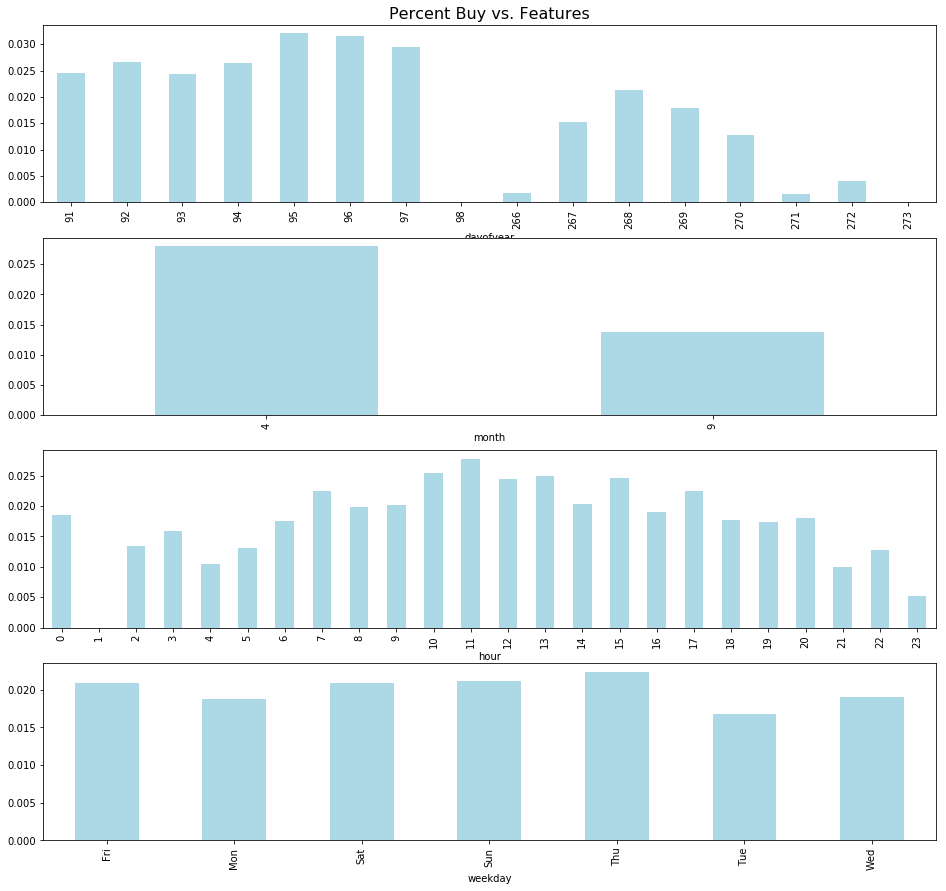

In [28]:
f, (ax1, ax2, ax3,ax4) = plt.subplots(4,1,figsize=(16,15))
features1.groupby('dayofyear')['buy'].mean().plot(kind='bar',color='lightblue',ax=ax1)
ax1.set_title('Percent Buy vs. Features',fontsize=16)
features1.groupby('month')['buy'].mean().plot(kind='bar',color='lightblue',ax=ax2)
features1.groupby('hour')['buy'].mean().plot(kind='bar',color='lightblue',ax=ax3)
features1.groupby('weekday')['buy'].mean().plot(kind='bar',color='lightblue',ax=ax4)
plt.show()

In [30]:
#Get clicks per category there should be 15 category columns.
clicks_per_cat = df.groupby('session_id').sum().iloc[:,-4:]
df1 = pd.concat([features2,clicks_per_cat],axis=1)

In [31]:
#SHOULD BE  FEATURES plus the BUY column
df1['buy'] = df1['buy'].astype(int)
df1.head()

,total_clicks,unique_items_seen,buy,duration,unique_categories_seen,first_click,item_id,Fri,Mon,Sat,...,item_214865117,item_214865120,item_214865212,item_214981102,item_643078783,item_Draw,Brand,No Category,Regular Category,Special Offer
session_id,,,,,,,,,,,,,,,,,,,,,
1,4,4,0,5.850000,1,2014-04-07 10:51:09.277,Draw,0,1,0,...,0,0,0,0,0,1,0,4,0,0
2,6,5,0,5.983333,1,2014-04-07 13:56:37.614,214662742,0,1,0,...,0,0,0,0,0,0,0,6,0,0
3,3,3,0,12.416667,1,2014-04-02 13:17:46.940,Draw,0,0,0,...,0,0,0,0,0,1,0,3,0,0
4,2,2,0,17.233333,1,2014-04-07 12:09:10.948,Draw,0,1,0,...,0,0,0,0,0,1,0,2,0,0
6,2,2,0,4.100000,1,2014-04-06 16:58:20.848,Draw,0,0,0,...,0,0,0,0,0,1,0,2,0,0


In [32]:
print 'Percent sessions with a buy: {}'.format(len(df1[df1['buy'] == 1])*1.0 / len(df1))

Percent sessions with a buy: 0.0202120192221


In [33]:
df1.shape

(55561, 4178)

### Create Baseline Model 

In [34]:
def confusion_matrix_as_df(actual,predicted,print_stats=False):

    cm = pd.crosstab(np.array(actual),np.array(predicted),rownames=['Actual'],colnames=['Predicted'],margins=True)

    TOTAL = cm.iloc[2,2]
    TN, FP = cm.iloc[0,0], cm.iloc[0,1]
    FN, TP = cm.iloc[1,0], cm.iloc[1,1]

    if print_stats:
        print 'False Positive Rate: {}'.format(FP/(cm.iloc[0,2]*1.0))
        print 'False Negative Rate: {}'.format(FN/(cm.iloc[1,2]*1.0))
        print 'True Positive Rate: {}'.format(TP/(cm.iloc[1,2]*1.0))
        print 'True Negative Rate: {}'.format(TN/(cm.iloc[0,2]*1.0))

        print '\nAccuracy: {}'.format((TP + TN) / float(TOTAL))
        print 'Precision: {}'.format(TP / float((TP + FP)))
        print 'Recall: {}'.format(TP / float(TP + FN))
        print 'F1-score: {}'.format(2 * TP / float((2*TP + FN + FP)))
    return cm, TN, TP, FN, FP

In [35]:
from sklearn.model_selection import train_test_split

non_features = ['buy','first_click','item_id']

X, y = df1.drop(non_features,axis=1), df1['buy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
print 'Training Samples: {}'.format(len(X_train))
print 'Test Samples: {}'.format(len(X_test))

Training Samples: 37225
Test Samples: 18336


In [37]:
#Baseline dummy classifier
#Random guessing with respect to the class distribution 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score

dum = DummyClassifier(strategy='stratified').fit(X_train,y_train)
pred = dum.predict(X_test)

cm, tn, tp, fn, fp = confusion_matrix_as_df(y_test,pred,print_stats=True)
print 'Kappa: {}'.format(cohen_kappa_score(y_test,pred))
cm

False Positive Rate: 0.0189644624882
False Negative Rate: 0.980281690141
True Positive Rate: 0.0197183098592
True Negative Rate: 0.981035537512

Accuracy: 0.962423647469
Precision: 0.0201149425287
Recall: 0.0197183098592
F1-score: 0.0199146514936
Kappa: 0.000761204031154


Predicted,0,1,All
Actual,,,
0,17640,341,17981
1,348,7,355
All,17988,348,18336


In [38]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression().fit(X_train,y_train)
pred = lr.predict(X_test)

cm, tn, tp, fn, fp = confusion_matrix_as_df(y_test,pred,print_stats=True)
print 'Kappa: {}'.format(cohen_kappa_score(y_test,pred))
cm

False Positive Rate: 0.000611756854457
False Negative Rate: 0.988732394366
True Positive Rate: 0.0112676056338
True Negative Rate: 0.999388243146

Accuracy: 0.980257417103
Precision: 0.266666666667
Recall: 0.0112676056338
F1-score: 0.0216216216216
Kappa: 0.0200833521562


Predicted,0,1,All
Actual,,,
0,17970,11,17981
1,351,4,355
All,18321,15,18336


In [39]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier().fit(X_train,y_train)
pred = rf.predict(X_test)

cm, tn, tp, fn, fp = confusion_matrix_as_df(y_test,pred,print_stats=True)
print 'Kappa: {}'.format(cohen_kappa_score(y_test,pred))
cm

False Positive Rate: 0.0057838829876
False Negative Rate: 0.960563380282
True Positive Rate: 0.0394366197183
True Negative Rate: 0.994216117012

Accuracy: 0.975730802792
Precision: 0.118644067797
Recall: 0.0394366197183
F1-score: 0.0591966173362
Kappa: 0.0500198622727


Predicted,0,1,All
Actual,,,
0,17877,104,17981
1,341,14,355
All,18218,118,18336


In [40]:
# Random forest most important features
print rf.feature_importances_
print np.argsort(rf.feature_importances_)[::-1][:10]

[ 0.04819717  0.09380487  0.54098171 ...,  0.04406615  0.01102277
  0.01574115]
[   2    1    0 4172 4174 4173   22   20   28   26]


In [41]:
#Top Features
X_train.head().iloc[:,[2,1,0,4172,4174,4173]]

,duration,unique_items_seen,total_clicks,No Category,Special Offer,Regular Category
session_id,,,,,,
11525049,4.216667,2,2,0,2,0
11538456,60.583333,2,3,0,3,0
4817,2.483333,2,3,3,0,0
17074,0.000000,1,1,1,0,0
11539714,32.333333,2,4,0,0,4


In [ ]:
df1[df1['buy'] == 1].describe()[['Fri','Mon','Tue','Wed','Thu','Sat','Sun']].sort_values('mean',axis=1)

In [ ]:
df1[df1['buy'] == 0].describe()[['Fri','Mon','Tue','Wed','Thu','Sat','Sun']].sort_values('mean',axis=1)